In [1]:
%matplotlib inline
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn

import os
import random
import numpy as np
from PIL import Image
from math import floor
import matplotlib.pyplot as plt

In [3]:
# Check GPU
device = torch.cuda.current_device()
torch.cuda.get_device_name(device)

'GeForce 940MX'

# Load MNIST Data

Data introducton: <br>
http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html <br>
Other dataset in pytorch<br>
http://pytorch-zh.readthedocs.io/en/latest/torchvision/datasets.html


root : given a directory to put processed/training.pt and processed/test.pt. <br>
train : True = Training set, False = Test set <br>
download : True = downloads the dataset from the internet and puts it in root directory. <br>
           If dataset already downloaded, place the processed dataset <br>
           (function available in mnist.py) in the processed folder.  <br>
num_workers : how many subprocesses to use for data loading. 0 means that the <br> 
              data will be loaded in the main process. (default: 0)  <br>

In [5]:
print('==================> Preparing data..................')
batch_size = 100

transform_train = transforms.Compose([
          transforms.RandomCrop(32, padding=4),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010))    
          ])

trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True, download=False,
                                           transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, 
                                            shuffle=True, num_workers=2)
print('Total data', len(trainset))


# 10 labels
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

==================> Preparing data..................
Total data 50000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([128, 3, 32, 32])
 ship plane  bird plane   car plane horse horse   car   car  ship   dog  ship  ship   dog   dog


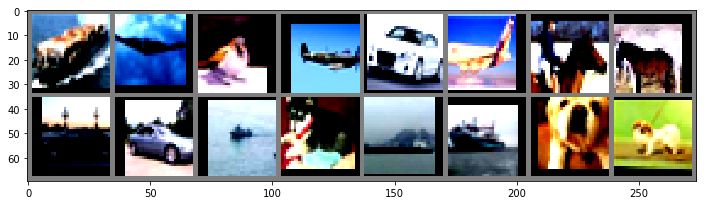

In [6]:
# Confirm the label is random
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
        
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.size())

# show images
imshow(torchvision.utils.make_grid(images[:16]))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(16)))

In [17]:
# Generate fack labels to test model capacity

train_labels = []
for i in range(len(trainset)):
    train_labels.append(random.randint(0, 9))
len(train_labels)

50000

# Building Model : GoogLeNet 
Source Code： 
https://github.com/kuangliu/pytorch-cifar/blob/master/models/googlenet.py

In [18]:
class Inception(nn.Module):
    def __init__(self, in_planes, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, n3x3red, kernel_size=1),
            nn.BatchNorm2d(n3x3red),
            nn.ReLU(True),
            nn.Conv2d(n3x3red, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(True),
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, n5x5red, kernel_size=1),
            nn.BatchNorm2d(n5x5red),
            nn.ReLU(True),
            nn.Conv2d(n5x5red, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
            nn.Conv2d(n5x5, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1,y2,y3,y4], 1)

In [19]:
class GoogLeNet(nn.Module):
    def __init__(self):
        super(GoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )

        self.a3 = Inception(192,  64,  96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)

        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.b4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.c4 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.d4 = Inception(512, 112, 144, 288, 32,  64,  64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.linear = nn.Linear(1024, 10)

    def forward(self, x):
        out = self.pre_layers(x)
        out = self.a3(out)
        out = self.b3(out)
        out = self.maxpool(out)
        out = self.a4(out)
        out = self.b4(out)
        out = self.c4(out)
        out = self.d4(out)
        out = self.e4(out)
        out = self.maxpool(out)
        out = self.a5(out)
        out = self.b5(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [24]:
# Test size
net = GoogLeNet()
loss_func = nn.CrossEntropyLoss(size_average=False)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, betas=(0.9, 0.99))
x = torch.randn(1, 3, 32,32)
y = net(Variable(x))
print(y.size())

torch.Size([1, 10])


# Training model with random labels

In [25]:
total_epoch = 10
trainset_size = len(train_images)
total_step = floor(trainset_size/batch_size)

NameError: name 'train_images' is not defined

In [ ]:
for epoch in range(1, total_epoch):
    
    if epoch % 2 == 0:
        correct = 0
        # Accuracy (each batch)
        for im, la in trainloader:
            pred = net(im).data.max(1)[1] # get the index of the max log-probability
            correct += pred.eq(train_labels.data).cpu().sum()
        Acc = correct / len(train_labels) * 100
        print('=====Accurate rate {}% in {} epoch====='.format(Acc, epoch))
    
    for idx, (images, labels) in enumerate(trainloader):
        # convert tensor to Variable
        images = Variable(images)
        Y = train_labels[idx*batch_size:(idx +1 )*batch_size]
        Y = Variable(torch.IntTensor(Y))
        
        # clear gradients w.r.t parameters
        optimizer.zero_grad()

        # forward pass
        outputs = net(images)

        # calculate loss
        loss = loss_func(outputs, Y)

        # get gradient w.r.t parameters
        loss.backward()

        # update parameters
        optimizer.step()
        
        if idx % 10 == 0:
            print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
                   epoch, (idx+1)*batch_size, len(train_labels), loss.data[0]))
            
    